In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ARIMA
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('./data/ghana_gdp.csv',
                 index_col='year', parse_dates=['year'])

display(df.head())
display(df.info())


,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GDP (current US$)  62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


None

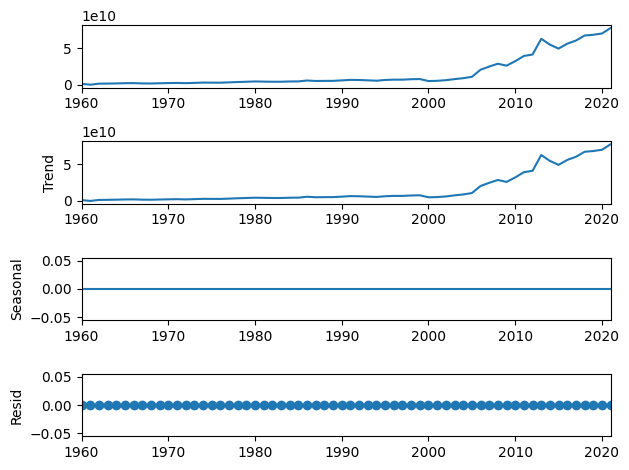

In [3]:
decompose = seasonal_decompose(df)
decompose.plot()
plt.show()


#### Наличие восходящего тренда, отсуствие сезонности

---

In [4]:
train_df = df[:-3]
test_df = df[-3:]


In [5]:
train_df[-2:-1]


,GDP (current US$)
year,
2017-01-01,6.040638e+10


---

### Модель скользящего среднего - base_line

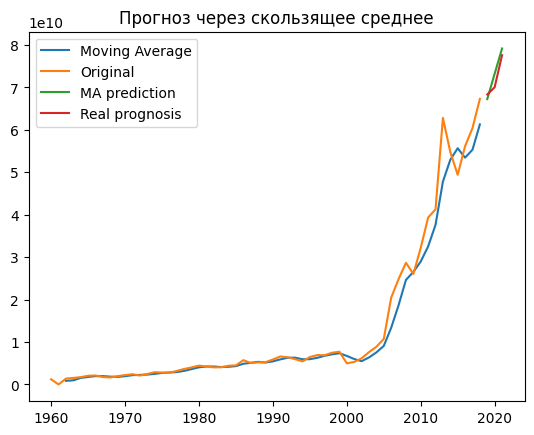

RMSE для прогноза MA: 2143290602.250167


In [39]:
# Moving average prediction
def ma_prediction(train_data, test_data=None, window_size=3, pred_num=3):

    data_ma = train_data.rolling(window_size).mean()
    last_values = data_ma.tail(window_size).values
    prediction = np.array([last_values[-1] +
                           (last_values[-1] - last_values[-2]) * i for i in range(1, pred_num + 1)])
    prediction = pd.DataFrame(
        prediction, columns=test_data.columns, index=test_data.index)
    return data_ma, prediction


ma_model, ma_pred = ma_prediction(train_df, test_df, window_size=3)
plt.plot(ma_model, label='Moving Average')
plt.plot(train_df, label='Original')
plt.plot(ma_pred, label='MA prediction')
plt.plot(test_df, label='Real prognosis')
plt.title('Прогноз через скользящее среднее')
plt.legend()
plt.show()
ma_rmse = np.sqrt(mean_squared_error(test_df, ma_pred))
print(f'RMSE для прогноза MA: {ma_mse}')


In [7]:
data_ma = train_df.rolling(3).mean()
last_values = data_ma.tail(3).values
[last_values[-1] + (last_values[-1] - last_values[-2])
 * i for i in range(1, 4)]
[2*i for i in range(1, 3 + 1)]


[2, 4, 6]

#### Вывод: модель скользящего среднего достаточно точно предсказывает значения для тестового периода в случае окна скольжения равного 2-3.

---

### Проверка на стационарность

In [124]:

def stationary(data, p_value=0.05):
    stats = adfuller(data)
    if stats[1] > p_value:
        print('Timeseries is not stationary')
    else:
        print('Timeseries is stationary')



stationary(df)


Timeseries is not stationary


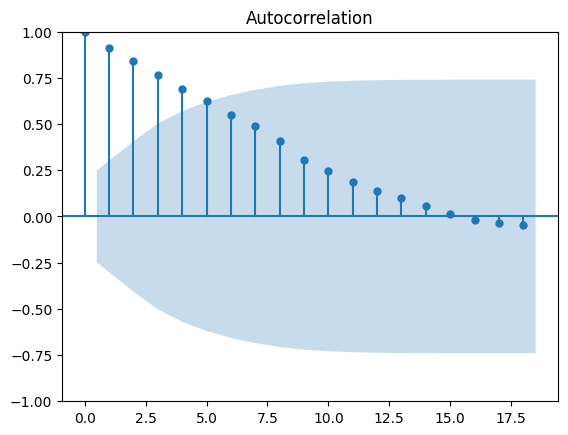

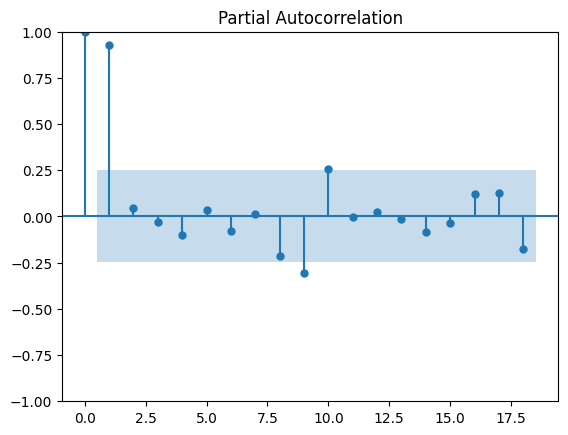

In [118]:
acf = plot_acf(df)
plt.show()
pacf = plot_pacf(df)
plt.show()


#### Вывод: ряд не стационарен для дальнейшей работы берем модель ARIMA, так как отсутсвует сезонная компонента (SARIMA не понадобится) и нет внешних данных (для SARIMAX)

---

### Коррелограммы

Произведем диференцирование ряда 1 степени

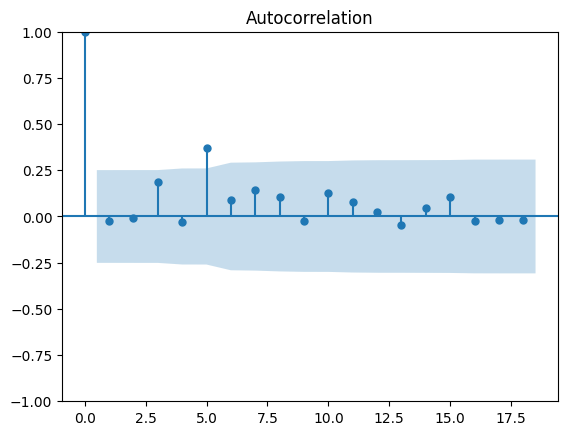

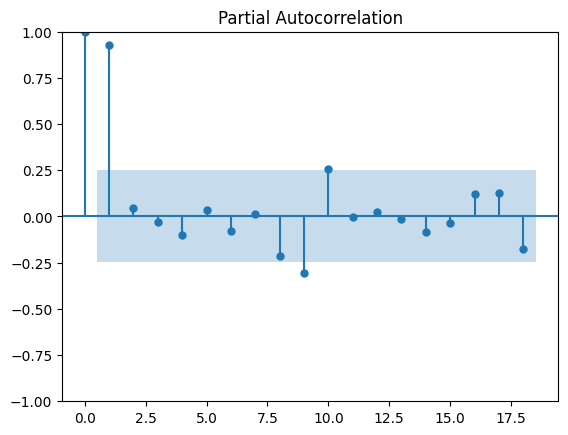

In [125]:
acf = plot_acf(df_diff := df.diff().dropna())
plt.show()
pacf = plot_pacf(df)
plt.show()


Вновь проведем тест стационраности

In [126]:
stationary(df_diff)

Timeseries is not stationary


Произведем дифиринцирование 2 и 3 порядка

In [130]:
stationary(df_diff_2 := df_diff.diff().dropna())

Timeseries is not stationary


In [131]:
stationary(df_diff_2.diff().dropna())

Timeseries is stationary


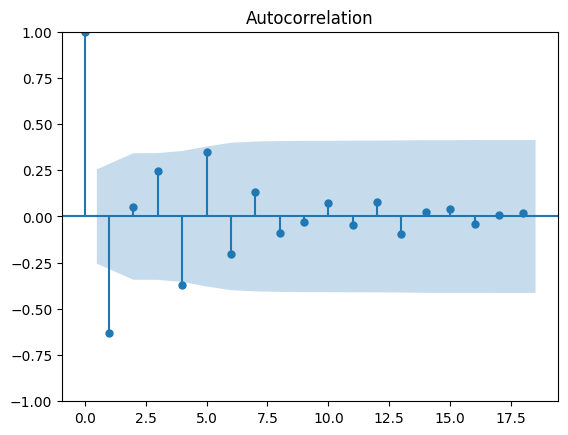

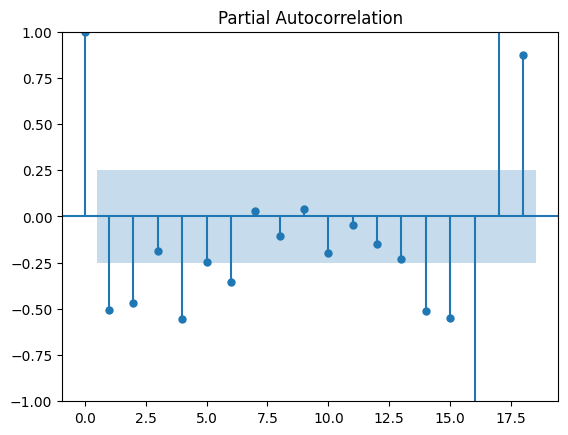

In [138]:
acf = plot_acf(df_diff_2.diff().dropna())
plt.show()
pacf = plot_pacf(df_diff_2)
plt.show()


На 3 этапе диференцирования мы получили стационарный ряд, это наше d для модели ARIMA

In [176]:
p = 1  # Определяется по коррелограмме частичной автокорреляции
q = 5  # Определяется по коррелограмме автокорреляции
d = 3# d найден ранее по тесту Дики-Фуллера, в нашем случае (не стационарного ряда) равен 1, т.к. пришлось дифференировать ряд 1 раз


In [177]:
arma_model = ARIMA(train_df.dropna(), order=(p, d, q))
arma_model_fit = arma_model.fit()
arma_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 3, 5)   Log Likelihood               -1323.504
Date:                Fri, 04 Aug 2023   AIC                           2661.008
Time:                        14:39:11   BIC                           2675.186
Sample:                    01-01-1960   HQIC                          2666.505
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6181      0.810     -0.763      0.445      -2.206       0.970
ma.L1         -1.3372      1.100     -1.216      0.224      -3.492       0.818
ma.L2         -0.4579      1.997     -0.229      0.819      -4.372       3.456
ma.L3          1.3992      0.580      2.411      0.016       0.262       2.536
ma.L4         -0.3987      0.992     -0.402      0.688      -2.343       1.546
ma.L5         -0.1746      0.645     -0.271      0.787      -1.439       1.090
sigma2      3.616e+19   4.09e-20   8.85e+38      0.000    3.62e+19    3.62e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               104.94
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):             174.69   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.38e+55. Standard errors may be unstable.
"""

In [178]:
# расчитываем предсказанные значения
pred_df = pd.DataFrame(index=test_df.index)

pred_df["GDP (model US$)"] = arma_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

# стоим доверительный интервал для предсказанных значений
forecast = arma_model_fit.get_forecast(len(test_df))
forecast_df = forecast.conf_int(alpha=0.05)  # это он и есть


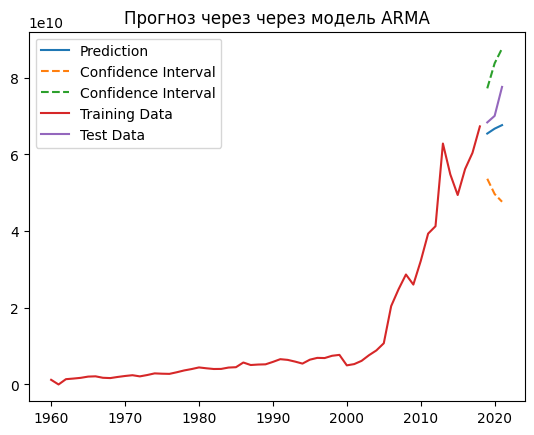

In [179]:
plt.plot(pred_df, label='Prediction')
plt.plot(forecast_df, linestyle='--', label='Confidence Interval')
plt.plot(train_df, label='Training Data')
plt.plot(test_df, label='Test Data')
plt.title('Прогноз через через модель ARMA')
plt.legend()
plt.show()


In [180]:
arma_rmse = np.sqrt(mean_squared_error(test_df, pred_df))
print(f'MSE для прогноза ARMA: {arma_mse}')


MSE для прогноза ARMA: 14966097134.926056


In [175]:
arma_rmse > ma_rmse


True

Модель авторегрессии на скользящем среднем показала худший результат нежели base-line MA, с достаточно широким доверительным интервалом

---

### Подбор параметров модели через pm.auto_arima

In [157]:
model_auto = pm.auto_arima(train_df)
forecast, conf_int = model_auto.predict(n_periods=3, return_conf_int=True)

auto_rmse = np.sqrt(mean_squared_error(test_df, forecast))
model_auto.arparams

<bound method ARIMA.arparams of ARIMA(order=(1, 2, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)>

In [99]:
conf_low = pd.DataFrame(conf_int.T[0], columns=[
                        'lower_bound'], index=test_df.index)
conf_high = pd.DataFrame(conf_int.T[1], columns=[
                         'upper_bound'], index=test_df.index)


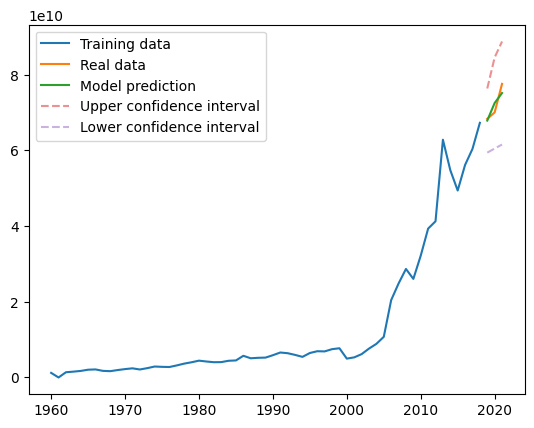

In [104]:
plt.plot(train_df, label='Training data')
plt.plot(test_df, label='Real data')
plt.plot(forecast, label='Model prediction')
plt.plot(conf_high, linestyle="--",
         label='Upper confidence interval', alpha=0.5)
plt.plot(conf_low, linestyle="--", label='Lower confidence interval', alpha=0.5)
plt.legend()
plt.show()


In [103]:
auto_rmse > ma_rmse


False

Вывод: алгоритм pm.auto_arima показал лучишй результат среди использованных подходов, а так же сформировал достаточно узкий доверительный интервал